In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
def print_nulls(df):
    
    out = df.isnull().sum()*100/df.isnull().isnull().count()
    
    pd.set_option('display.max_rows', len(out))
    print(out)
    pd.reset_option('display.max_rows')

In [3]:
def print_outliers(lower_inner_upper, df):
    
    if lower_inner_upper == 'lower':
        
        print('Continuious Variables', '\n')

        for column in df.select_dtypes(include='number'):
            print(column)
            for threshold in [95, 90, 85, 80, 75]:
                lower_bound = np.percentile(df[column], [100-threshold])[0]
                
                print('Beyond the upper {}th percentile there are {} outliers'.format(threshold, 
                    len((np.where((df[column] < lower_bound))[0]))
                ))
                
            if (df[column].nunique() < 5):
                print('\n')
                print('Possible Categorical Variable')
                print('There are {} unique values'.format(df[column].nunique()))
                print(df[column].value_counts())
            print('\n')
    
    elif lower_inner_upper == 'inner':
        
        print('Continuious Variables', '\n')
    
        for column in df.select_dtypes(include='number'):
            print(column)
            for threshold in [95, 90, 85, 80, 75]:
                alpha = 100 - threshold
                upper_bound, lower_bound = np.percentile(df[column]
                                                         , [(100 - alpha/2), (0 + alpha/2)]) 

                print("Beyond the inner {}th percentile there are {} outliers.".format(threshold,
                        len((np.where((df[column] > upper_bound) 
                                      | (df[column] < lower_bound))[0]))
                    ))

            if (df[column].nunique() < 5):
                print('\n')
                print('Possible Categorical Variable')
                print('There are {} unique values'.format(df[column].nunique()))
                print(df[column].value_counts())
            print('\n')
            
    elif lower_inner_upper == 'upper':
    
        print('Continuious Variables', '\n')

        for column in df.select_dtypes(include='number'):
            print(column)
            for threshold in [95, 90, 85, 80, 75]:
                upper_bound = np.percentile(df[column], [threshold])[0]
                
                print('Beyond the lower {}th percentile there are {} outliers'.format(threshold, 
                    len((np.where((df[column] > upper_bound))[0]))
                ))
                
            if (df[column].nunique() < 5):
                print('\n')
                print('Possible Categorical Variable')
                print('There are {} unique values'.format(df[column].nunique()))
                print(df[column].value_counts())
            print('\n')
        
        
    
    print('Categorical Variables', '\n')
    
    for column in df.select_dtypes(include='object'):
        print(column)
        print('There are {} unique values'.format(df[column].nunique()))
        print(df[column].value_counts())
        print('\n')

## Introduction



## Load the Data Set

This is a mock data set created specifically for learning purposes. It can be found at: https://www.kaggle.com/gireeshs/household-monthly-electricity-bill?select=Household+energy+bill+data.csv

In [4]:
df = pd.read_csv('electricity.csv')

In [5]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_rooms           1000 non-null   int64  
 1   num_people          1000 non-null   int64  
 2   housearea           1000 non-null   float64
 3   is_ac               1000 non-null   int64  
 4   is_tv               1000 non-null   int64  
 5   is_flat             1000 non-null   int64  
 6   ave_monthly_income  1000 non-null   float64
 7   num_children        1000 non-null   int64  
 8   is_urban            1000 non-null   int64  
 9   amount_paid         1000 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 78.2 KB


,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
0,3,3,742.570,1,1,1,9675.930,2,0,560.481
1,1,5,952.990,0,1,0,35064.790,1,1,633.284
2,3,1,761.440,1,1,1,22292.440,0,0,511.879
3,0,5,861.320,1,1,0,12139.080,0,0,332.992
4,1,8,731.610,0,1,0,17230.100,2,1,658.286
5,0,5,837.240,0,1,1,24661.810,2,1,793.242
6,4,5,679.040,0,1,0,28184.430,1,1,570.383
7,3,4,1044.650,0,0,1,16912.690,2,1,585.405
8,2,4,713.900,1,0,0,26058.280,0,1,653.201
9,1,6,734.430,0,0,0,22545.500,2,1,606.015


## EDA and Data Cleaning

In [6]:
# there appears to be no null values but we will 
# check that there are no missing values or errors in the data set

In [7]:
for column in df.columns:
    problems = []
    for entry in df[column]:
        try:
            float(entry)
        except:
            problems.append(entry)
    print(column, '\n-----------------------------------------------')
    print('Problem values are:')
    print(problems)
    print('\n')

num_rooms 
-----------------------------------------------
Problem values are:
[]


num_people 
-----------------------------------------------
Problem values are:
[]


housearea 
-----------------------------------------------
Problem values are:
[]


is_ac 
-----------------------------------------------
Problem values are:
[]


is_tv 
-----------------------------------------------
Problem values are:
[]


is_flat 
-----------------------------------------------
Problem values are:
[]


ave_monthly_income 
-----------------------------------------------
Problem values are:
[]


num_children 
-----------------------------------------------
Problem values are:
[]


is_urban 
-----------------------------------------------
Problem values are:
[]


amount_paid 
-----------------------------------------------
Problem values are:
[]




In [8]:
# There are no obvious missing or problem values in our variables. Lets do a quick visualization of their 
# distributions

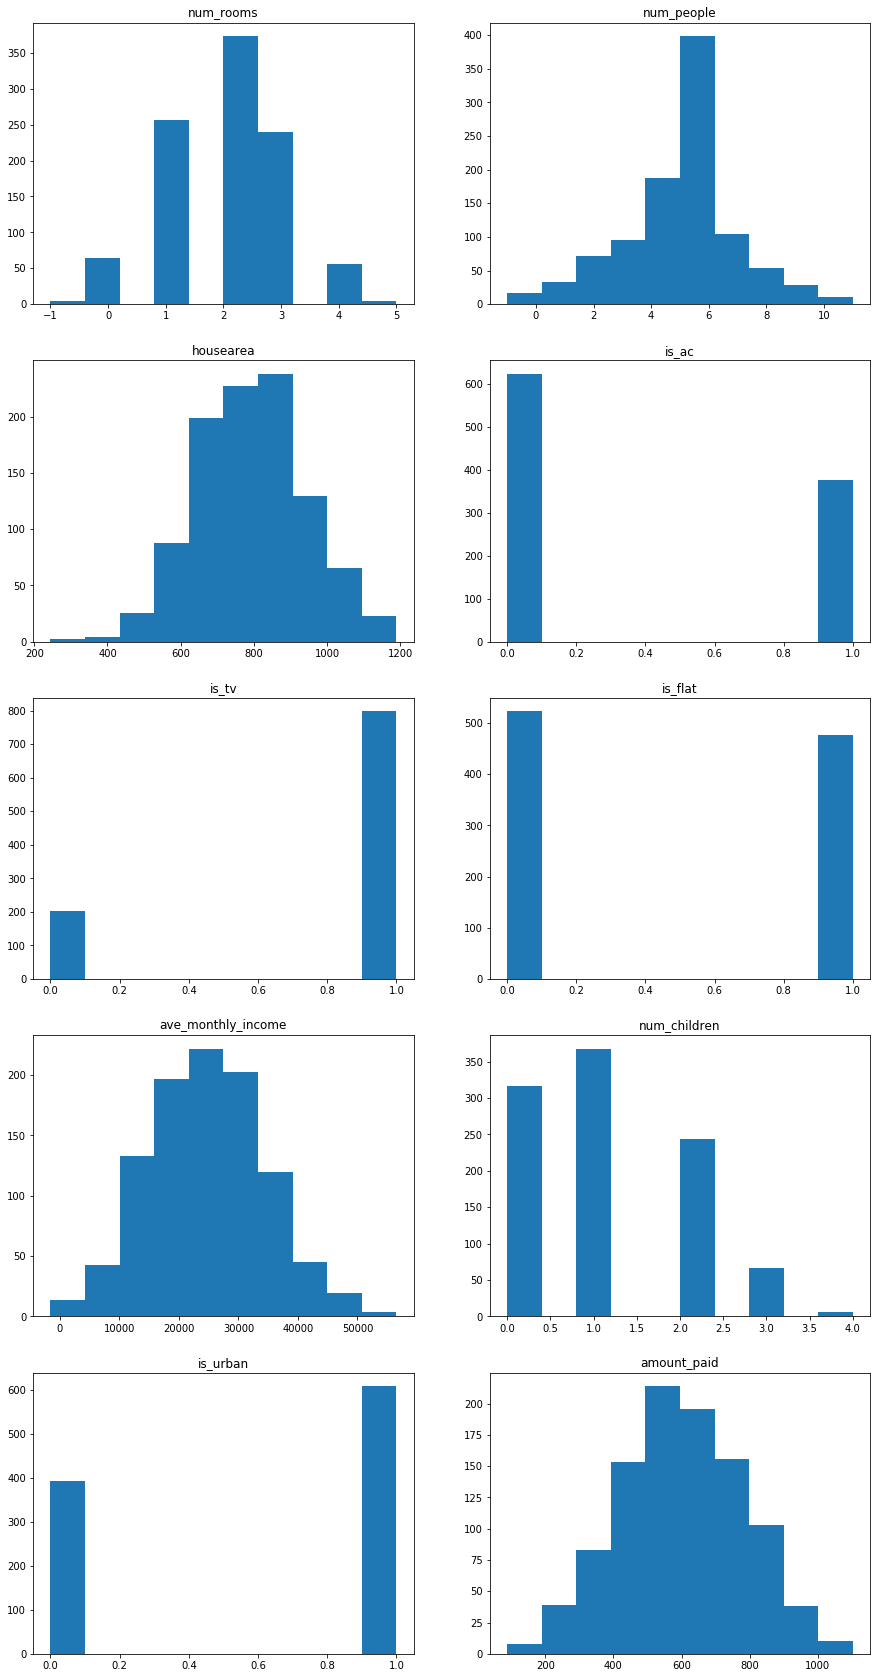

In [9]:
plt.figure(figsize=(15, len(df.columns)*3))
for i, column in enumerate(df.columns):
    plt.subplot(len(df.columns)/2, 2, i+1)
    plt.hist(df[column])
    plt.title(column)

In [10]:
# Columns 'ave_monthly_income', 'num_rooms', and 'num_people' appear to have values < 1. 
# These values don't make sense.
# First let'see how many occurances there are and then fill them with the mean for that variable.

In [11]:
len(df[df['ave_monthly_income'] < 1])

6

In [12]:
len(df[df['num_rooms'] < 1])

70

In [13]:
len(df[df['num_people'] < 1])

17

In [14]:
people_mask = df['num_people'] < 1
rooms_mask = df['num_rooms'] < 1
income_mask = df['ave_monthly_income'] < 1

df.loc[rooms_mask, 'num_rooms'] = round(df['num_rooms'].mean()) # round so that we get whole numbers
df.loc[people_mask, 'num_people'] = round(df['num_people'].mean()) # round so that we get whole numbers
df.loc[income_mask, 'ave_monthly_income'] = df['ave_monthly_income'].mean()

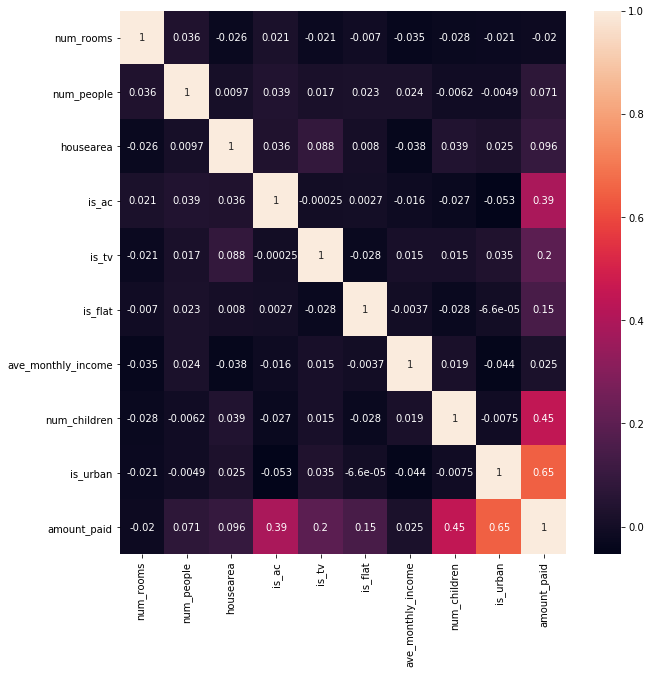

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

In [15]:
# Check for outliers in the data

print_outliers('inner', df)

Continuious Variables 

num_rooms
Beyond the inner 95th percentile there are 4 outliers.
Beyond the inner 90th percentile there are 4 outliers.
Beyond the inner 85th percentile there are 60 outliers.
Beyond the inner 80th percentile there are 60 outliers.
Beyond the inner 75th percentile there are 60 outliers.


num_people
Beyond the inner 95th percentile there are 11 outliers.
Beyond the inner 90th percentile there are 72 outliers.
Beyond the inner 85th percentile there are 72 outliers.
Beyond the inner 80th percentile there are 126 outliers.
Beyond the inner 75th percentile there are 198 outliers.


housearea
Beyond the inner 95th percentile there are 50 outliers.
Beyond the inner 90th percentile there are 100 outliers.
Beyond the inner 85th percentile there are 150 outliers.
Beyond the inner 80th percentile there are 200 outliers.
Beyond the inner 75th percentile there are 250 outliers.


is_ac
Beyond the inner 95th percentile there are 0 outliers.
Beyond the inner 90th percentile t

In [16]:
# treat the outliers with winsorization

conts = ['num_people', 'num_rooms', 'num_children', 'ave_monthly_income', 'amount_paid']

df_winsorized = df.copy()

for feature in conts:
    df_winsorized[feature] = winsorize(df[feature], (0.05, 0.05))

In [17]:
# next we will check the normality of our continuous features
for df in [df_winsorized, df]:
    for column in conts:
        print(column, '\n', '------------------------------------')
        print('Jarque-Berra test results: Statistic:{} | p-value: {}'.format(jarque_bera(df[column])[0]
              , jarque_bera(df[column])[1]))
        print('Normal Test results: Statistic: {} | p-value: {}'.format(normaltest(df[column])[0]
                                                                       , normaltest(df[column])[1]))
        print('\n')
    print('===============================================================================')   

num_people 
 ------------------------------------
Jarque-Berra test results: Statistic:22.660590890116353 | p-value: 1.2003702128393634e-05
Normal Test results: Statistic: 60.46724406039658 | p-value: 7.408065000851249e-14


num_rooms 
 ------------------------------------
Jarque-Berra test results: Statistic:35.4376425362454 | p-value: 2.0175007109379806e-08
Normal Test results: Statistic: 42.75423994134829 | p-value: 5.200376148734382e-10


num_children 
 ------------------------------------
Jarque-Berra test results: Statistic:52.67890083712633 | p-value: 3.6385339186040255e-12
Normal Test results: Statistic: 93.40341382528908 | p-value: 5.220431389937695e-21


ave_monthly_income 
 ------------------------------------
Jarque-Berra test results: Statistic:34.33858155041953 | p-value: 3.4951977978536775e-08
Normal Test results: Statistic: 132.57401374653017 | p-value: 1.6289910306567553e-29


amount_paid 
 ------------------------------------
Jarque-Berra test results: Statistic:34.46

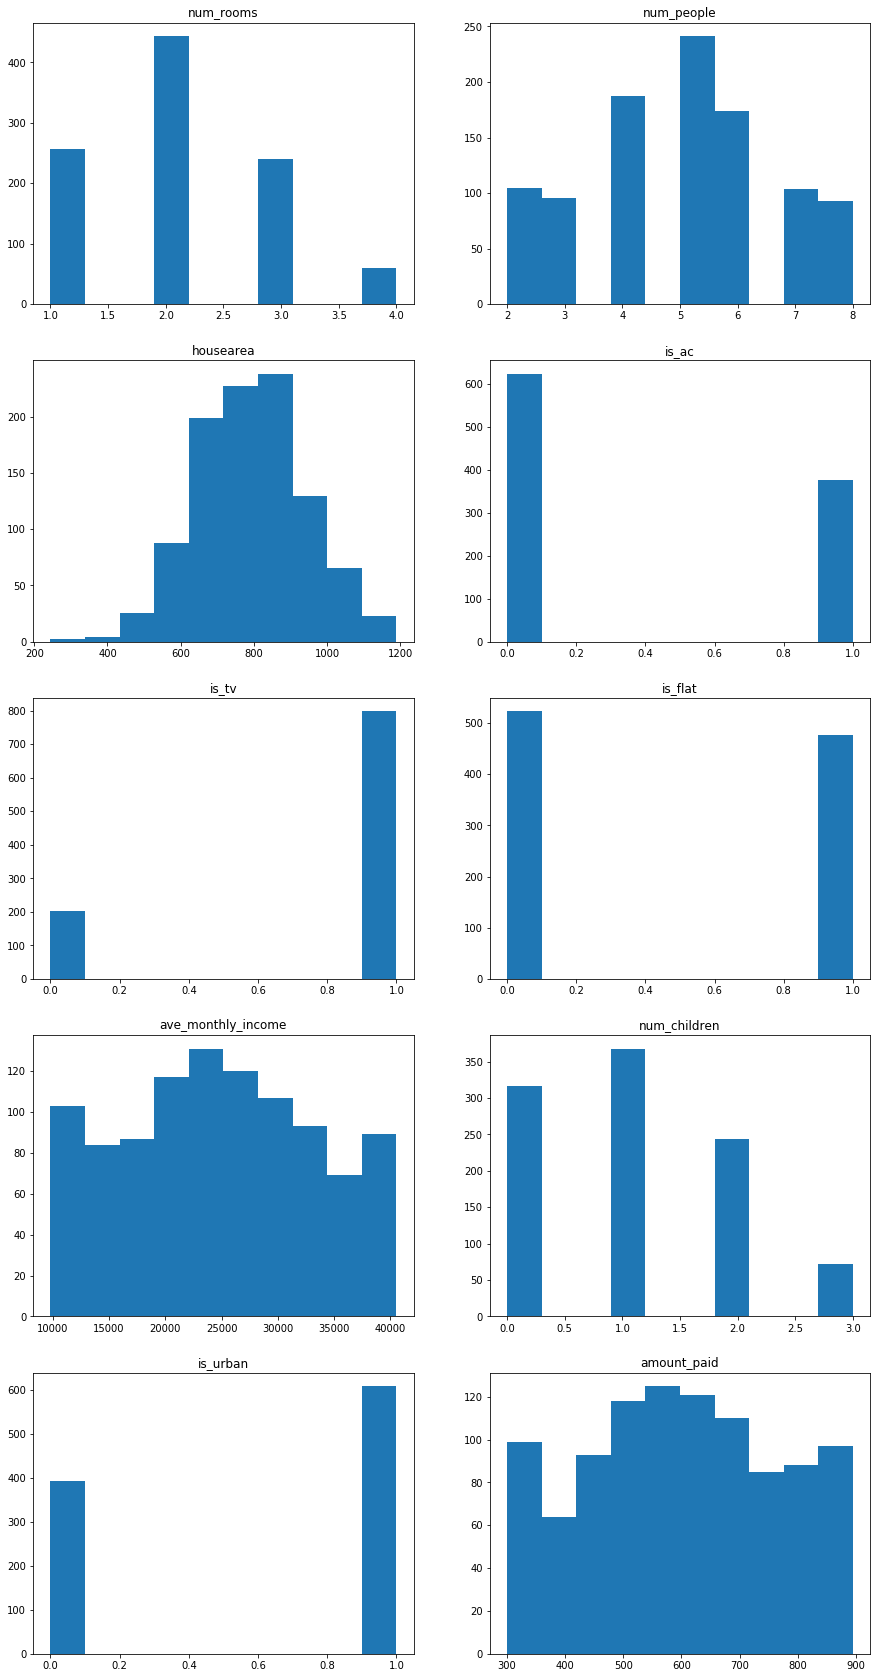

In [18]:
plt.figure(figsize=(15, len(df_winsorized.columns)*3))
for i, column in enumerate(df_winsorized.columns):
    plt.subplot(len(df.columns)/2, 2, i+1)
    plt.hist(df_winsorized[column])
    plt.title(column)

In [19]:
#There are relatively few outliers for each variable. 
#Treating the outliers with a winsorization process dramatically affects their distributions as shown above. 
#Later we will compare performance of models with outliers intact and with outliers treated via winsorization

# All of the strictly continuous features are normally distributed or close. We could treat the non normal 
# features as ordinal categorical since they all have values less than 5. We will do this for the first
# iteration and check model performance.

# encode the dummy variables

cats = ['is_ac', 'is_urban', 'num_children', 'num_rooms', 'is_tv', 'is_flat']

df_cleaned = df.copy()

for column in cats:
    df_cleaned.drop(column, axis=1, inplace=True)
    df_cleaned = pd.concat([df_cleaned, pd.get_dummies(df[column], prefix=column, drop_first=True)]
                           , axis=1)
    
for column in cats:
    df_winsorized.drop(column, axis=1, inplace=True)
    df_winsorized = pd.concat([df_winsorized, pd.get_dummies(df[column], prefix=column, drop_first=True)]
                           , axis=1)

In [29]:
df_winsorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_people          1000 non-null   int64  
 1   housearea           1000 non-null   float64
 2   ave_monthly_income  1000 non-null   float64
 3   amount_paid         1000 non-null   float64
 4   is_ac_1             1000 non-null   uint8  
 5   is_urban_1          1000 non-null   uint8  
 6   num_children_1      1000 non-null   uint8  
 7   num_children_2      1000 non-null   uint8  
 8   num_children_3      1000 non-null   uint8  
 9   num_children_4      1000 non-null   uint8  
 10  num_rooms_2         1000 non-null   uint8  
 11  num_rooms_3         1000 non-null   uint8  
 12  num_rooms_4         1000 non-null   uint8  
 13  num_rooms_5         1000 non-null   uint8  
 14  is_tv_1             1000 non-null   uint8  
 15  is_flat_1           1000 non-null   uint8  
dtypes: floa

In [20]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_people          1000 non-null   int64  
 1   housearea           1000 non-null   float64
 2   ave_monthly_income  1000 non-null   float64
 3   amount_paid         1000 non-null   float64
 4   is_ac_1             1000 non-null   uint8  
 5   is_urban_1          1000 non-null   uint8  
 6   num_children_1      1000 non-null   uint8  
 7   num_children_2      1000 non-null   uint8  
 8   num_children_3      1000 non-null   uint8  
 9   num_children_4      1000 non-null   uint8  
 10  num_rooms_2         1000 non-null   uint8  
 11  num_rooms_3         1000 non-null   uint8  
 12  num_rooms_4         1000 non-null   uint8  
 13  num_rooms_5         1000 non-null   uint8  
 14  is_tv_1             1000 non-null   uint8  
 15  is_flat_1           1000 non-null   uint8  
dtypes: floa

In [21]:
# the DataFrame is cleaned and ready for regression

# we will begin with OLS regression first

### Feature Selection

We have only three moderatly correlated variables: air conditioning, urbanity, and the number of children. However since there is no multicolinearity in our variables it can't hurt to include all of them to begin with and test performance. So we will begin with all features intact use multiple passes to select our features.

## Performance of Data with Outliers Intact

In [22]:
X = df_cleaned.drop('amount_paid', axis=1)
y = df_cleaned['amount_paid']

In [23]:
# run a perliminary model with StatsModel to check the significance of our variables

X_examine = sm.add_constant(X)

sm.OLS(y, X_examine).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_paid   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     482.3
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:44:40   Log-Likelihood:                -5557.9
No. Observations:                1000   AIC:                         1.115e+04
Df Residuals:                     984   BIC:                         1.123e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                122.8833     14.722      8.347      0.000      93.993     151.774
num_people             5.0087      1.063      4.712      0.000       2.923       7.095
housearea              0.0378      0.014      2.772      0.006       0.011       0.065
ave_monthly_income     0.0009      0.000      4.366      0.000       0.001       0.001
is_ac_1              163.5421      4.154     39.371      0.000     155.391     171.694
is_urban_1           249.5185      4.116     60.617      0.000     241.441     257.596
num_children_1        91.0705      4.878     18.669      0.000      81.498     100.643
num_children_2       183.9897      5.429     33.891      0.000     173.336     194.643
num_children_3       269.9131      8.584     31.443      0.000     253.067     286.759
num_children_4       332.5452     26.223     12.682      0.000     281.087     384.004
num_rooms_2           -2.6238      4.980     -0.527      0.598     -12.396       7.149
num_rooms_3            3.3195      5.698      0.583      0.560      -7.862      14.501
num_rooms_4           -5.9653      9.375     -0.636      0.525     -24.364      12.433
num_rooms_5           35.6026     31.983      1.113      0.266     -27.160      98.366
is_tv_1               75.4339      5.028     15.001      0.000      65.566      85.302
is_flat_1             59.3738      4.025     14.750      0.000      51.474      67.273
==============================================================================
Omnibus:                      343.810   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.441
Skew:                           0.036   Prob(JB):                     1.84e-11
Kurtosis:                       1.913   Cond. No.                     4.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# All the features except number of rooms are significant so we will drop that one and then compare

X.drop(['num_rooms_2', 'num_rooms_3', 'num_rooms_4', 'num_rooms_5'], axis=1, inplace=True)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

In [26]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)


y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8769596310162234
-----Test set statistics-----
R-squared of the model in the test set is: 0.8851300010288667
Mean absolute error of the prediction is: 54.313577009641655
Mean squared error of the prediction is: 4040.475243925869
Root mean squared error of the prediction is: 63.564732705533096
Mean absolute percentage error of the prediction is: 10.731148649569375


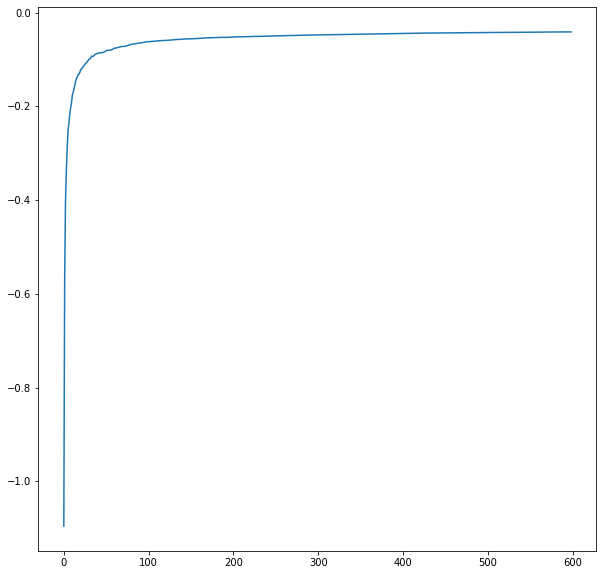

In [27]:
scores = []
for i in range(1,600):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)
    scores.append(cross_val_score(knn, X_train, y_train, cv=5).mean())

plt.figuredf_cleaned = df.copy()(figsize=(10,10))
plt.plot(scores)

In [28]:
knn = neighbors.KNeighborsRegressor(n_neighbors=300, weights='distance')
knn.fit(X_train, y_train)

y_preds_train = knn.predict(X_train)
y_preds_test = knn.predict(X_test)

print("R-squared of the model in the training set is: {}".format(knn.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(knn.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 1.0
-----Test set statistics-----
R-squared of the model in the test set is: -0.04664439738912507
Mean absolute error of the prediction is: 157.30420059081592
Mean squared error of the prediction is: 36815.01536277719
Root mean squared error of the prediction is: 191.87239343578634
Mean absolute percentage error of the prediction is: 35.49435096035461


### Performance of Winsorized Data

In [32]:
X2 = df_winsorized.drop(['amount_paid', 'num_rooms_2', 'num_rooms_3', 'num_rooms_4', 'num_rooms_5'], axis=1)
y2 = df_winsorized['amount_paid']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.25, random_state=1312)



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_paid   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     592.1
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:50:45   Log-Likelihood:                -5531.0
No. Observations:                1000   AIC:                         1.109e+04
Df Residuals:                     988   BIC:                         1.114e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                159.6404     14.211     11.233      0.000     131.753     187.528
num_people             5.7050      1.136      5.020      0.000       3.475       7.935
housearea              0.0301      0.013      2.275      0.023       0.004       0.056
ave_monthly_income     0.0009      0.000      3.816      0.000       0.000       0.001
is_ac_1              149.2514      4.032     37.012      0.000     141.338     157.165
is_urban_1           235.1707      3.995     58.873      0.000     227.332     243.010
num_children_1        82.9614      4.726     17.554      0.000      73.687      92.236
num_children_2       168.7718      5.256     32.108      0.000     158.457     179.087
num_children_3       239.9575      8.326     28.820      0.000     223.619     256.296
num_children_4       241.7984     25.459      9.498      0.000     191.838     291.758
is_tv_1               66.4548      4.878     13.623      0.000      56.882      76.027
is_flat_1             53.9263      3.904     13.814      0.000      46.266      61.587
==============================================================================
Omnibus:                      142.484   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.820
Skew:                           0.066   Prob(JB):                     1.67e-08
Kurtosis:                       2.082   Cond. No.                     3.44e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
lrm2 = LinearRegression()

lrm2.fit(X_train2, y_train2)


y_preds_train = lrm.predict(X_train2)
y_preds_test = lrm.predict(X_test2)

print("R-squared of the model in the training set is: {}".format(lrm2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8643901178726571
-----Test set statistics-----
R-squared of the model in the test set is: 0.8764371300985114
Mean absolute error of the prediction is: 56.19392312739306
Mean squared error of the prediction is: 4271.043634311008
Root mean squared error of the prediction is: 65.35322206525863
Mean absolute percentage error of the prediction is: 11.365616838548144


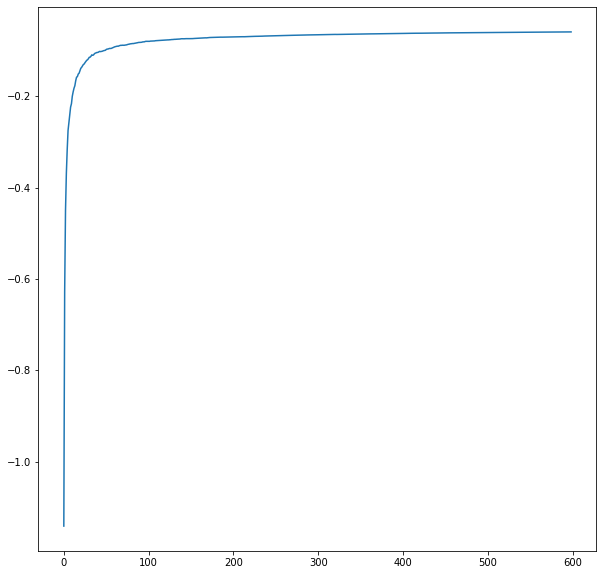

In [35]:
scores = []
for i in range(1,600):
    knn2 = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    knn2.fit(X_train2, y_train2)
    scores.append(cross_val_score(knn2, X_train2, y_train2, cv=5).mean())

plt.figure(figsize=(10,10))
plt.plot(scores)

In [36]:
knn2 = neighbors.KNeighborsRegressor(n_neighbors=300, weights='distance')
knn2.fit(X_train2, y_train2)

y_preds_train = knn.predict(X_train2)
y_preds_test = knn.predict(X_test2)

print("R-squared of the model in the training set is: {}".format(knn2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(knn2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 1.0
-----Test set statistics-----
R-squared of the model in the test set is: -0.03934250421542829
Mean absolute error of the prediction is: 157.6389802769789
Mean squared error of the prediction is: 36767.739551554245
Root mean squared error of the prediction is: 191.74915789007846
Mean absolute percentage error of the prediction is: 35.69782589007943


## Comparing the results




OLS clearly preformed better of the two models. While OLS performance could use some improvement it is much better than the KNN model which seems to have a strong overfitting problem. Moreover the models improved performance as k approaches n suggests that our KNN model is not much better at estimation than taking the mean value of our target variable. 

The OLS model performs better on the test set indicating that there is not an overfitting issue there. The OLS model likely is underperforming because of not enough relevant features to explain the target. 

One consideration is that this data set may not contain enough information to create an accurate prediction. Moreover because it is likely randomly generated this could impact the performance of a KNN model. Whereas a linear regression model would be better able to fit random data than data that is naturally derived.   